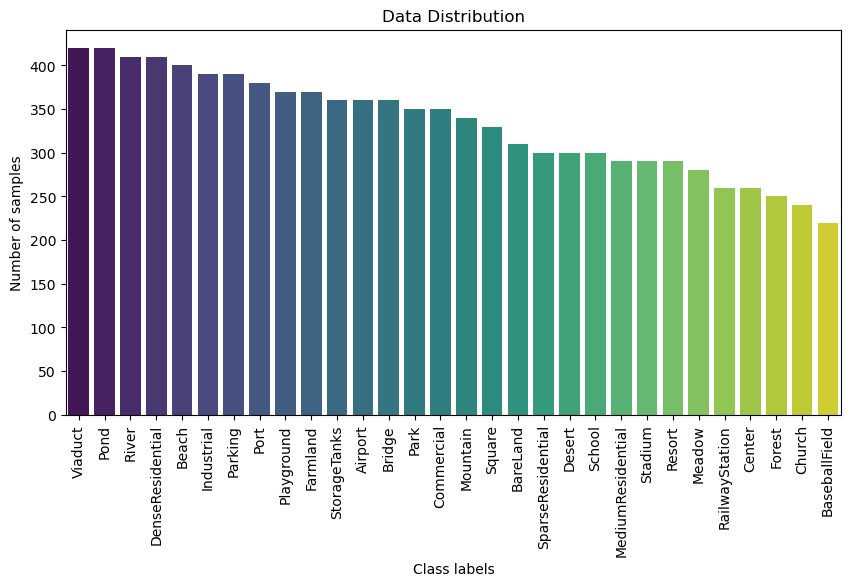

Found 8000 validated image filenames belonging to 30 classes.
Found 1000 validated image filenames belonging to 30 classes.
Found 1000 validated image filenames belonging to 30 classes.
Epoch 1/50


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 671s 3s/step - accuracy: 0.1068 - loss: 3.9258 - val_accuracy: 0.4720 - val_loss: 1.9202 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.4607 - loss: 1.9489 - val_accuracy: 0.6860 - val_loss: 1.1663 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - accuracy: 0.6301 - loss: 1.3225 - val_accuracy: 0.7890 - val_loss: 0.7768 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 567s 2s/step - accuracy: 0.7154 - loss: 1.0226 - val_accuracy: 0.8020 - val_loss: 0.7167 - learning_rate: 1.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.7918 - loss: 0.8120 - val_accuracy: 0.8410 - val_loss: 0.5521 - learning_rate: 1.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - accuracy: 0.8086 - loss: 0.7041 - val_accuracy: 0.8630 - val_loss: 0.4763 - learning_rate: 1.0000e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 566s 2s/step - accuracy: 0.83

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def plot_data_distribution(directory):
    labels = []
    for subdir in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, subdir)):
            for file in os.listdir(os.path.join(directory, subdir)):
                labels.append(subdir)
    label_counts = pd.Series(labels).value_counts()
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
    plt.title("Data Distribution")
    plt.ylabel("Number of samples")
    plt.xlabel("Class labels")
    plt.xticks(rotation=90)
    plt.show()

def split_train_validation_test_data(directory, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1, random_seed=42):
    train_data = []
    validation_data = []
    test_data = []

    for subdir in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, subdir)):
            files = os.listdir(os.path.join(directory, subdir))
            train_files, temp_files = train_test_split(files, train_size=train_ratio, random_state=random_seed)
            validation_files, test_files = train_test_split(temp_files, train_size=validation_ratio / (validation_ratio + test_ratio), random_state=random_seed)
            train_data += [(os.path.join(directory, subdir, f), subdir) for f in train_files]
            validation_data += [(os.path.join(directory, subdir, f), subdir) for f in validation_files]
            test_data += [(os.path.join(directory, subdir, f), subdir) for f in test_files]
    
    return train_data, validation_data, test_data

def train_data_gen(train_data):
    train_df = pd.DataFrame(train_data, columns=['filename', 'class'])
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    return train_datagen.flow_from_dataframe(train_df, x_col='filename', y_col='class', target_size=(224, 224), batch_size=32, class_mode='sparse')

def validation_data_gen(validation_data):
    validation_df = pd.DataFrame(validation_data, columns=['filename', 'class'])
    validation_datagen = ImageDataGenerator(rescale=1./255)
    return validation_datagen.flow_from_dataframe(validation_df, x_col='filename', y_col='class', target_size=(224, 224), batch_size=32, class_mode='sparse')

def test_data_gen(test_data):
    test_df = pd.DataFrame(test_data, columns=['filename', 'class'])
    test_datagen = ImageDataGenerator(rescale=1./255)
    return test_datagen.flow_from_dataframe(test_df, x_col='filename', y_col='class', target_size=(224, 224), batch_size=32, class_mode='sparse', shuffle=False)

def load_feature_extractor_model(trainable_layers=None):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    if trainable_layers is not None:
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = False
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True
    else:
        for layer in base_model.layers:
            layer.trainable = False
    return base_model

def train():
    # Load and plot data distribution
    directory = 'C:/Users/Admin/Downloads/AID'
    plot_data_distribution(directory)

    # Split the data
    train_data, validation_data, test_data = split_train_validation_test_data(directory, train_ratio=0.8, validation_ratio=0.1, test_ratio=0.1)

    # Create data generators
    train_generator = train_data_gen(train_data)
    validation_generator = validation_data_gen(validation_data)
    test_generator = test_data_gen(test_data)

    # Load feature extractor model
    base_model = load_feature_extractor_model(trainable_layers=50)

    # Construct the model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')

    # Confusion matrix and classification report
    y_true = test_generator.classes
    y_pred = np.argmax(model.predict(test_generator), axis=-1)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()))

    print('Confusion Matrix')
    print(conf_matrix)
    print('Classification Report')
    print(class_report)

    return model, history

if __name__ == '__main__':
    model, history = train()
